# Imports and paths

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
from tqdm import tqdm
from multiprocessing import Pool, cpu_count


In [16]:
npy_file = ("/projects/synsight/data/website_data/jump_compounds_matrix.npy")
METADATA_FILE = ("/projects/synsight/data/website_data/jump_compounds_matrix_metadata.parquet")
output_file = '/projects/synsight/data/website_data/nearest_neighbors.h5'  # Output HDF5 file

# Histograms

In [4]:


# Charger la matrice depuis le fichier .npy
matrix = np.load(DATA_FILE)


In [5]:
all_values = matrix.flatten()

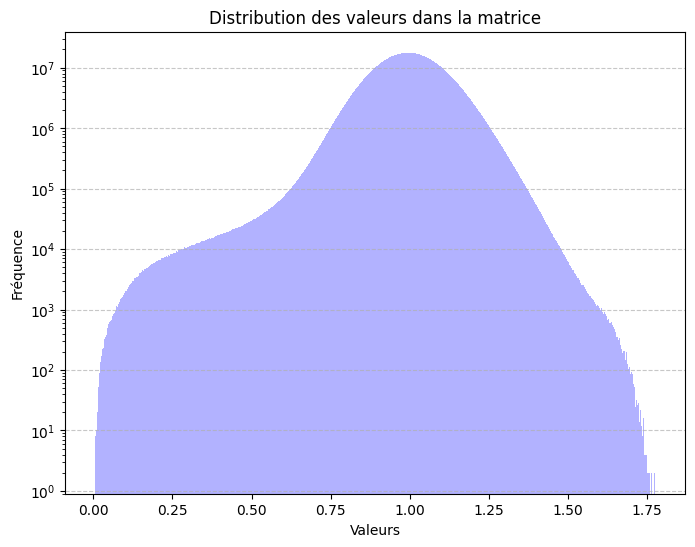

In [8]:

# Afficher la distribution des valeurs avec un histogramme
plt.figure(figsize=(8, 6))
plt.hist(all_values, bins=5000, log=True, color='blue', alpha=0.3)
plt.title('Distribution des valeurs dans la matrice')
plt.xlabel('Valeurs')
plt.ylabel('Fréquence')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

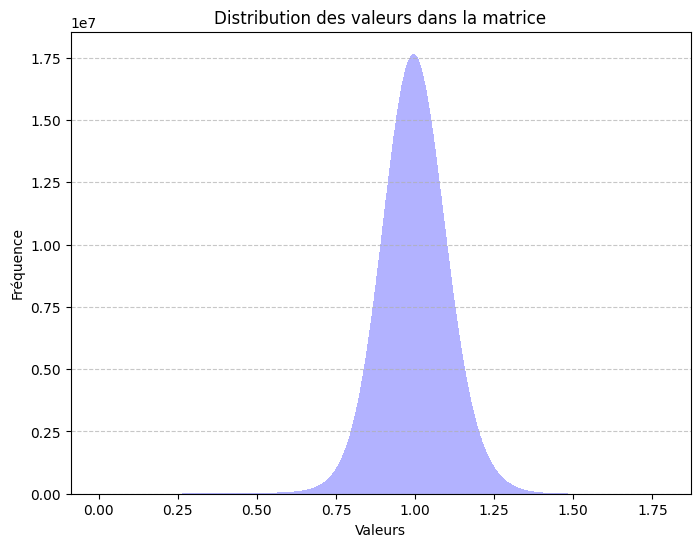

In [7]:

# Afficher la distribution des valeurs avec un histogramme
plt.figure(figsize=(8, 6))
plt.hist(all_values, bins=5000, color='blue', alpha=0.3)
plt.title('Distribution des valeurs dans la matrice')
plt.xlabel('Valeurs')
plt.ylabel('Fréquence')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Precompute distances

In [4]:
m = 1000  # Number of nearest neighbors

In [5]:
# Load metadata
metadata = pd.read_parquet(METADATA_FILE)
metadata_ids = metadata['Metadata_JCP2022'].values  # Unique molecule IDs


In [20]:
metadata_ids

array(['JCP2022_108820', 'JCP2022_078486', 'JCP2022_086327', ...,
       'JCP2022_080538', 'JCP2022_061369', 'JCP2022_077623'],
      shape=(112605,), dtype=object)

In [6]:
matrix = np.load(npy_file)

In [23]:
def process_row(i):
    """
    Process a single row of the distance matrix to find the m closest neighbors
    and include the distance to a specific molecule.

    Args:
        i (int): Index of the row in the distance matrix.

    Returns:
        tuple: (molecule_id, closest_ids, closest_distances)
    """
    distances = matrix[i]

    # Distance to the target molecule (JCP2022_033924)
    target_index = np.where(metadata_ids == 'JCP2022_033924')[0][0]
    dmso_distance = distances[target_index]

    # Find m closest molecules using partial sorting (excluding self if needed)
    closest_indices = np.argpartition(distances, m)[1:m+1]  # Top m indices (unsorted)
    closest_distances = distances[closest_indices]

    # Sort these m indices to ensure proper order
    sorted_indices_within_chunk = np.argsort(closest_distances)
    closest_indices = closest_indices[sorted_indices_within_chunk]
    closest_distances = closest_distances[sorted_indices_within_chunk]

    # Get IDs for the closest molecules
    closest_ids = metadata_ids[closest_indices]

    # Return the results
    return metadata_ids[i], closest_ids, closest_distances, dmso_distance

# Parallel processing
with Pool(processes=cpu_count()) as pool:
    # Use tqdm for progress tracking
    results = list(tqdm(pool.imap(process_row, range(matrix.shape[0])), total=matrix.shape[0]))






100%|██████████| 112605/112605 [00:44<00:00, 2550.88it/s]


In [25]:
# Save results to HDF5
with h5py.File(output_file, 'w') as h5f:
    for molecule_id, closest_ids, closest_distances, dmso_distance in results:
        group = h5f.create_group(molecule_id)
        group.create_dataset('closest_ids', data=closest_ids.astype('S'))  # Save IDs as strings
        group.create_dataset('distances', data=closest_distances)
        group.create_dataset('dmso_distance', data=dmso_distance)

In [26]:
import h5py

# Parameters
molecule_id = 'JCP2022_080538'  # Example molecule ID

# Access the HDF5 file
with h5py.File(output_file, 'r') as h5f:
    # Check if the molecule_id exists in the HDF5 file
    if molecule_id in h5f:
        print(f"Molecule ID {molecule_id} found.")
        
        # Access the datasets
        closest_ids = h5f[f'{molecule_id}/dmso_distance'][:].astype(str)  # Convert bytes to strings
        distances = h5f[f'{molecule_id}/distances'][:]
        
        # Print the results
        print(f'Closest molecules to {molecule_id}:')
        print('IDs:', closest_ids)
        print('Distances:', distances)
    else:
        print(f"Molecule ID {molecule_id} not found in the HDF5 file.")


Molecule ID JCP2022_080538 found.


In [31]:
import h5py

# File path
H5_DISTANCE_FILE = output_file

# Query molecule ID
query_id = "JCP2022_080538"  # Replace with the molecule ID you want to query

# Open the HDF5 file and retrieve the `dmso_distance`
with h5py.File(H5_DISTANCE_FILE, 'r') as h5f:
    if query_id in h5f:
        dmso_distance = h5f[f"{query_id}/dmso_distance"][()]
        print(f"DMSO distance for {query_id}: {dmso_distance}")
    else:
        print(f"Molecule ID {query_id} not found in the HDF5 file.")


DMSO distance for JCP2022_080538: 0.9586309171626763


# Add molecular ids (zinc, chembl, pubchem)

In [9]:
data[data['Metadata_InChI']=='InChI=1S/C2H6OS/c1-4(2)3/h1-2H3']

NameError: name 'data' is not defined

In [1]:
data_test = data.sample(n=100)

NameError: name 'data' is not defined

In [8]:
data_test

,Metadata_JCP2022,Metadata_InChI,path_embedding
41701,JCP2022_079314,InChI=1S/C21H28N4O4S/c1-3-25(19-9-11-20(29-2)1...,/projects/synsight/data/openphenom/norm_2_comp...
104466,JCP2022_057732,InChI=1S/C16H14FN3O/c17-11-5-7-12(8-6-11)18-16...,/projects/synsight/data/openphenom/norm_2_comp...
54533,JCP2022_111816,"InChI=1S/C19H23N3O2/c1-19(2,3)15-6-4-14(5-7-15...",/projects/synsight/data/openphenom/norm_2_comp...
37426,JCP2022_091363,InChI=1S/C16H12N2O3/c19-16-12-3-1-2-4-13(12)17...,/projects/synsight/data/openphenom/norm_2_comp...
46220,JCP2022_107676,InChI=1S/C17H18N2O5/c20-12(11-3-4-13-14(9-11)2...,/projects/synsight/data/openphenom/norm_2_comp...
...,...,...,...
47256,JCP2022_100199,InChI=1S/C20H18N4O5S2/c1-29-16-8-7-14(19(26)22...,/projects/synsight/data/openphenom/norm_2_comp...
25215,JCP2022_077105,InChI=1S/C21H20N4O4/c1-13-6-5-9-18(14(13)2)24-...,/projects/synsight/data/openphenom/norm_2_comp...
6267,JCP2022_100805,InChI=1S/C23H25ClN2O4/c1-25(14-18-9-10-19(30-1...,/projects/synsight/data/openphenom/norm_2_comp...
19149,JCP2022_080990,InChI=1S/C9H12ClN/c10-9-5-3-8(4-6-9)2-1-7-11/h...,/projects/synsight/data/openphenom/norm_2_comp...


In [ ]:
# Add new columns for metadata (initialize them with default values, e.g., None)
data['Zinc_id'] = None  # Replace None with the logic to populate Zinc ids if available
data['Canonical_SMILES'] = None  # Replace None with the logic to populate Canonical SMILES if available
data['PubChem_id'] = None  # Replace None with the logic to populate PubChem ids if available



In [ ]:

updated_parquet_file_path = "updated_file.parquet"  # Replace with your desired output file path
data.to_parquet(updated_parquet_file_path, index=False)

print("Metadata columns added successfully!")
